# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier From Scratch</font>


As discussed in the previous notebook, the steps for training Neural Networks are:


* Step 1 - Understand your problem
* Step 2 - Dataset Exploration
    * Step 2A - Get the data
    * Step 2B - Explore & understand your data
    * Step 2C - Create a sample data from the dataset
* Step 3 - Data preparation
* Step 4 - Train a simple model on sample data, and check the pipeline before training the full network
* Step 5 - Train on full data
* Step 6 - Improve your model
* Step 7 - Generate Submission file

Follow Steps 1-4 exactly as you did in the previous notebook. Here, you will implement Steps 5, 6 & 7 from scratch.


**Design a model that achieves `>=80%` Public Test accuracy on the given dataset.**


This notebook carries **75** points out of a total of **100**. <font style="color:red">The sections which carry marks are in Red.</font>

#### Points Distribution - Maximum Points: 75


<div align="center">
    <table>
        <tr><td><h3>Number</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Configurations</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Confusion Matrix</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Submission File Generation</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Kaggle Submission Score</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


**Kaggle Submission Score Points Distribution**

<div align="center">
    <table>
        <tr><td><h3>Number</h3></td> <td><h3>Public Test Set Accuracy</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>>= 85%</h3></td> <td><h3>50</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>84%</h3></td> <td><h3>48</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>83%</h3></td> <td><h3>46</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>82%</h3></td><td><h3>44</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>81%</h3></td> <td><h3>42</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>80%</h3></td> <td><h3>40</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>< 80%</h3></td> <td><h3>0</h3></td> </tr>
    </table>
</div>

**Note: Percentages will be rounded off to the nearest integer.**

**After completing the project, upload and submit the notebook to the lab for feedback.**

**<font style="color:red">You need to achieve atleast 80% accuracy on the Public test leaderboard to successfully complete this project.</font>**


**<font style="color:red">Build your own model from scratch, and do not use any pre-trained models/weights.</font>**

# <font style="color:blue">Step 1: Understand Your problem </font><a name="step1"></a>
Already covered in the previous notebook.

In [1]:
# Colab-gdrive import
from google.colab import drive; drive.mount("/remote/")

import os
import glob
import random
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras as tfk
from dataclasses import dataclass

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import platform

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

Mounted at /remote/


### <font style="color:green">Set Seeds</font>

Use this function to set random seeds for CPU and GPU operations in order to make training deterministic and to ensure reproducibility.

**Note:** GPU Usage on Kaggle.

1. Please switch from P100 to **T4 x2** GPUs due to an identified error with P100 GPUs. The `.predict(...`) method on P100 GPUs is returning incorrect results during training and inference.

3. We've updated this notebook to now support dual GPU training with T4 x2 GPUs. Please use the updated code as a reference for your Kaggle projects to ensure accurate results.

In case you prefer single GPU setup instead of dual GPU (which can be a bit slow on Kaggle), make the following changes in below code cell:     

```python
        # Instead of this try-except block
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
```

Use this:

```python
        try:
            # Make just the first GPU device visible to the code.
            tf.config.set_visible_devices(gpus[0], 'GPU')
            
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
```

In [2]:
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42

  random.seed(SEED_VALUE)
  np.random.seed(SEED_VALUE)
  tf.random.set_seed(SEED_VALUE)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      # Currently, memory growth needs to be the same across GPUs
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

  return

set_seeds()

In [3]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

# Printing the number of devices that are in sync with the MirroredStrategy.
# This indicates how many replicas of the model are being trained in parallel.
print('Number of devices: {}'.format(DISTRIBUTE_STRATEGY.num_replicas_in_sync))

Number of devices: 1


# <font style="color:blue">Step 2: Dataset Exploration</font>

Already covered in the previous notebook.

# <font style="color:blue">Step 3. Data Preparation</font>

Already covered in the previous notebook.

In [5]:
def data_augmentation_preprocess(seed:int=2000):
  """Combines multiple augmentations in a single processing pipeline.

  Reference:
    https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

  """
  return tfk.Sequential([
    tfk.layers.RandomFlip("horizontal", seed=seed),
    tfk.layers.RandomFlip("vertical", seed=seed),
    tfk.layers.RandomRotation(0.25, fill_mode='nearest', seed=seed),
    tfk.layers.RandomZoom(
      height_factor=(-.5, .5),
      width_factor=(-.5, .5),
      fill_mode='nearest',
      seed=seed
    ),
    tfk.layers.RandomContrast(0.25, seed=seed),
    tfk.layers.RandomBrightness(0.25, seed=seed),
  ])


def get_data(*, data_root, target_size=(224, 224), batch_size=32, data_augmentation=False):

  train_dataset = tfk.utils.image_dataset_from_directory(
    f"{data_root}/Train",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=target_size,
    shuffle=True,
  )

  valid_dataset = tfk.utils.image_dataset_from_directory(
    f"{data_root}/Valid",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=target_size,
    shuffle=False,
  )

  if data_augmentation:
    data_augmentation_pipeline = data_augmentation_preprocess()
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))


  train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
  valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

  return train_dataset, valid_dataset

# <font style="color:blue">Step 4: Train Your Model</font>

Now, create the training pipeline and train your model on the full data.

## <font style="color:red">4.1. Configurations [5 Points]</font>

To achieve good results, change the parameters given in these configurations.

### <font style="color:green">4.1.1. Training Configuration</font>

In [6]:
@dataclass
class TrainingConfig:
  MODEL_NAME: str = "Classifier"
  BATCH_SIZE: int = 32
  EPOCHS: int = 50
  LEARNING_RATE: float = 0.01

  # For tensorboard logging and saving checkpoints
  root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
  root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

  # Current log and checkpoint directory.
  log_dir = "version_0"
  checkpoint_dir = "version_0"

  # Use multiprocessing during training.
  use_multiprocessing: bool = True if platform.system() == "Linux" else False

  # Number of workers to use for training.
  num_workers: int = 4

### <font style="color:green">4.1.2. Dataset Configuration</font>

In [7]:
@dataclass
class DatasetConfig:
  DATA_ROOT: str = "/remote/MyDrive/shared/dataset/opencv-TF-course-project-1-image-classification/dataset"
  DATA_SHAPE: tuple = (224, 224, 3)
  NUM_CLASSES: int = 4

## <font style="color:blue">4.2. Callbacks</font>


Let’s define the different callbacks we'll be using during training.

In [8]:
def get_callbacks(
  training_config=TrainingConfig,
  monitor="val_accuracy",
  mode="max",
  save_weights_only=False,
  save_best_only=True,
):

  # Initialize tensorboard callback for logging.
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=training_config.log_dir,
    histogram_freq=20,
    write_graph=True,
    update_freq="epoch",
    write_images=True,
  )


  checkpoint_filepath = training_config.checkpoint_dir

  # Update file path if saving best model weights.
  if save_weights_only:
    checkpoint_filepath = os.path.join(training_config.checkpoint_dir, "model.ckpt")

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=save_weights_only,
    monitor=monitor,
    mode=mode,
    save_best_only=save_best_only,
    verbose=1,
  )

  return [tensorboard_callback, model_checkpoint_callback]

## <font style="color:blue">4.3. Logging Setup</font>

A function for initializing directories so that it saves tensorboard and model checkpoints for different training versions.

In [9]:
def setup_log_directory(training_config=TrainingConfig):
  '''Tensorboard Log and Model checkpoint directory Setup'''

  if os.path.isdir(training_config.root_log_dir):
    # Get all folders numbers in the root_log_dir
    folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

    # Find the latest version number present in the log_dir
    last_version_number = max(folder_numbers)

    # New version name
    version_name = f"version_{last_version_number + 1}"

  else:
    version_name = training_config.log_dir

  # Update the training config default directory
  training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
  training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

  # Create new directory for saving new experiment version
  os.makedirs(training_config.log_dir,        exist_ok=True)
  os.makedirs(training_config.checkpoint_dir, exist_ok=True)

  print(f"Logging at: {training_config.log_dir}")
  print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

  return training_config, version_name

## <font style="color:blue">4.4. Plot Loss and Accuracy</font>

Use this function to plot loss and accuracy for training and validation results.

In [10]:
def plot_history(
  train_loss=None,
  val_loss=None,
  train_metric=None,
  val_metric=None,
  colors=["blue", "green"],
  loss_legend_loc="upper center",
  acc_legend_loc="upper left",
  fig_size=(15, 10),
):

  plt.rcParams["figure.figsize"] = fig_size
  fig = plt.figure()
  fig.set_facecolor("white")

  # Loss Plots
  plt.subplot(2, 1, 1)

  train_loss_range = range(len(train_loss))
  plt.plot(
    train_loss_range,
    train_loss,
    color=f"tab:{colors[0]}",
    label=f"Train Loss",
  )

  valid_loss_range = range(len(val_loss))
  plt.plot(
    valid_loss_range,
    val_loss,
    color=f"tab:{colors[1]}",
    label=f"Valid Loss",
  )

  plt.ylabel("Loss")
  plt.legend(loc=loss_legend_loc)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.grid(True)
  plt.title("Training and Validation Loss")

  # Accuracy Plots
  plt.subplot(2, 1, 2)

  train_metric_range = range(len(train_metric))
  plt.plot(
    train_metric_range,
    train_metric,
    color=f"tab:{colors[0]}",
    label=f"Train Accuracy",
  )

  val_metric_range = range(len(val_metric))
  plt.plot(
    val_metric_range,
    val_metric,
    color=f"tab:{colors[1]}",
    label=f"Valid Accuracy",
  )

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(loc=acc_legend_loc)
  plt.grid(True)
  plt.title("Training and Validation Accuracy")

  plt.show(block=block_plot)

  return

## <font style="color:red">4.5. Define Model [10 Points]</font>

**Next, define your CNN model.**

Keep iterating. Do this by training various models.

Experiment by changing the:

* Number of layers.
* Number of filters/units per layer.
* Different types of layers, e.g., dropout, batch normalization.
* Different combination of layers.

In [11]:
class Classifier(tfk.Model):
  """Classifier wrapper class.
  """
  fimodel: str = ...
  fimodelcp: str = ...

  # Constructor
  def __init__(self, num_classes=DatasetConfig.NUM_CLASSES, shape=DatasetConfig.DATA_SHAPE, name:str=TrainingConfig.MODEL_NAME, **kwargs):
    super(Classifier, self).__init__(name=name, **kwargs)

    self.model = tfk.Sequential(
      name=name,
      layers=[
        # tfk.layers.Input(shape=shape),
        tfk.layers.InputLayer(input_shape=shape),
        tfk.layers.Rescaling(1./255),

        tfk.layers.Conv2D(16, 3, activation="relu"),
        tfk.layers.BatchNormalization(),
        tfk.layers.MaxPooling2D(pool_size=(2, 2)),

        tfk.layers.Conv2D(32, 3, activation="relu"),
        tfk.layers.BatchNormalization(),
        tfk.layers.MaxPooling2D(pool_size=(2, 2)),

        tfk.layers.Conv2D(64, 3, activation="relu"),
        tfk.layers.BatchNormalization(),
        tfk.layers.MaxPooling2D(pool_size=(2, 2)),

        tfk.layers.Conv2D(128, 3, activation="relu"),
        tfk.layers.BatchNormalization(),
        tfk.layers.MaxPooling2D(pool_size=(2, 2)),

        tfk.layers.Flatten(),
        tfk.layers.Dense(num_classes, activation="softmax")
      ],
    )


  def call(self, x):
    """Custom call method."""
    return self.model(x)

## <font style="color:blue">4.6. Training Pipeline</font>


In this function, we bring together all the different functions we've defined so far.

In [12]:
def train_model(
  dataset_config=DatasetConfig,
  training_config=TrainingConfig,
  data_augmentation=True,
  print_summary=True,
):

  # Get training and validation datasets.
  train_dataset, valid_dataset = get_data(
    data_root=dataset_config.DATA_ROOT,
    target_size=dataset_config.DATA_SHAPE[:2],
    batch_size=training_config.BATCH_SIZE,
    data_augmentation=data_augmentation,
  )

  for images, labels in valid_dataset:
    print("X Shape:", images.shape, "Y Shape:", labels.shape)
    break


  # Get model
  model = Classifier()

  # Initialize optimizer
  # optimizer = tfk.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)

  # Compile model
  model.compile(
    loss="categorical_crossentropy",
    optimizer=tfk.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
    metrics=["accuracy"],
  )

  # Print model summary
  if print_summary:
    model.summary()

  # Get training callbacks
  callbacks = get_callbacks(training_config)

  # Train model
  training_results = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=training_config.EPOCHS,
    # epochs=50,
    callbacks=callbacks,
    workers=training_config.num_workers,
    use_multiprocessing=training_config.use_multiprocessing
  )

  print("training_results keys:", training_results.history.keys())

  return model, training_results

## <font style="color:blue">4.7. Training</font>

Experiment with:

- `Optimizers` and `learning rate schedulers`(You can  get good results even without a learning rate scheduler.)
- Regularization techniques like Data Augmentation, Dropout, BatchNorm.
- Number of epochs.

In [13]:
# training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(TrainingConfig)

Logging at: Logs_Checkpoints/Model_logs/version_0
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_0


In [14]:
# Start training

trained_model, training_results = train_model(
  dataset_config=DatasetConfig,
  training_config=training_config,
  data_augmentation=False,
  print_summary=False,
)

Found 3997 files belonging to 4 classes.
Found 786 files belonging to 4 classes.
X Shape: (32, 224, 224, 3) Y Shape: (32, 4)
Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 15.5309 - accuracy: 0.3890 
Epoch 1: val_accuracy improved from -inf to 0.27346, saving model to Logs_Checkpoints/Model_checkpoints/version_0
125/125 [==============================] - 763s 6s/step - loss: 15.5309 - accuracy: 0.3890 - val_loss: 9.1939 - val_accuracy: 0.2735
Epoch 2/50
123/125 [============================>.] - ETA: 0s - loss: 3.2283 - accuracy: 0.5135
Epoch 2: val_accuracy improved from 0.27346 to 0.39780, saving model to Logs_Checkpoints/Model_checkpoints/version_0
125/125 [==============================] - 22s 171ms/step - loss: 3.2009 - accuracy: 0.5144 - val_loss: 1.5352 - val_accuracy: 0.3978
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.6125
Epoch 3: val_accuracy improved from 0.39780 to 0.64999, saving model to Logs_Checkpoint

## <font style="color:blue">4.8. Loss and Accuracy Plot</font>

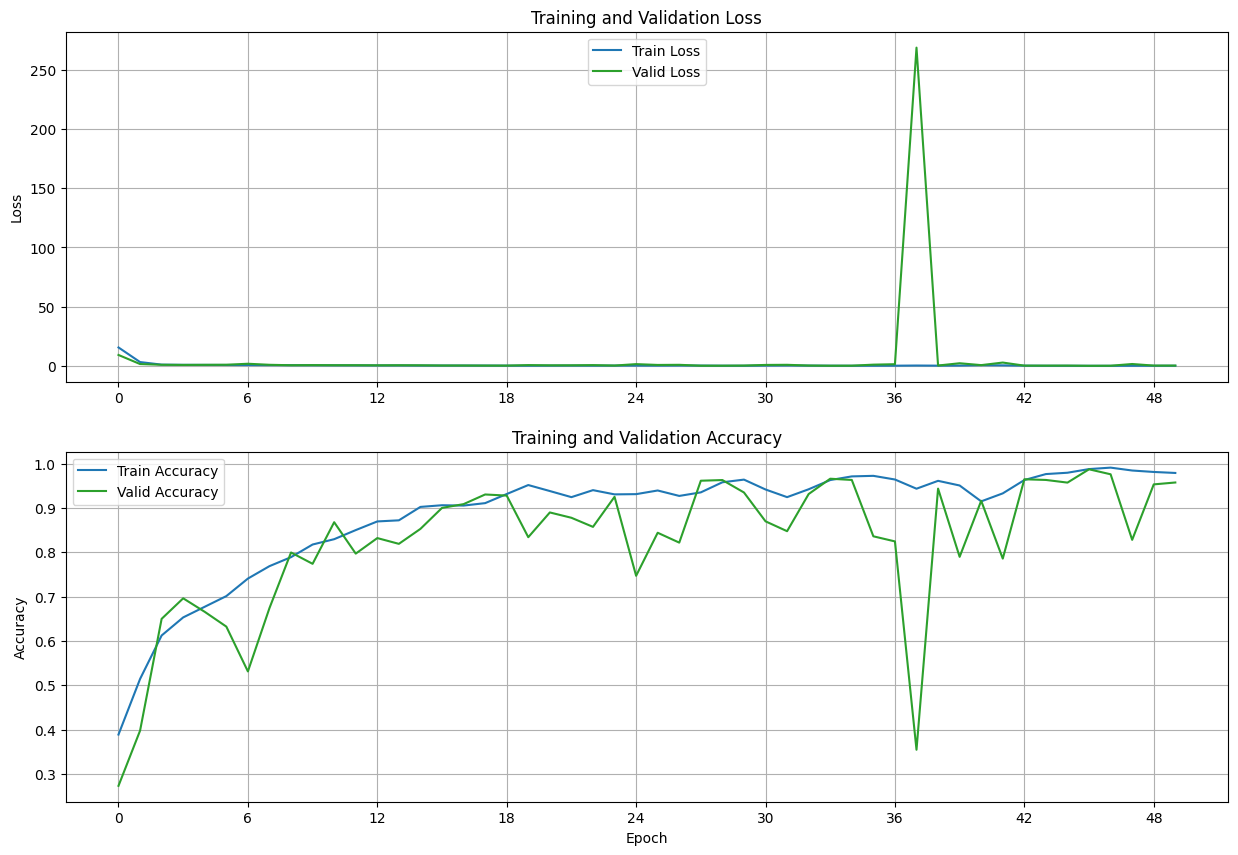

In [15]:
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
  train_loss=loss,
  train_metric=accuracy,
  val_loss=val_loss,
  val_metric=val_accuracy,
  loss_legend_loc="upper center",
  acc_legend_loc="upper left",
)

# <font style="color:blue">Step 5: Sample Prediction</font>

Show some sample predictions.

## <font style="color:blue">5.1. Reload the Model</font>

A function to help reload the model or the weights saved during training.

In [16]:
def recreate_model(path, load_weights=False, config=DatasetConfig, **kwargs):
  """
  For reloading trained model
  Args:
    path: current_version checkpoint path
    load_weights: Whether the files saved at path contains model weights
            or the Entire model configuration
    **kwargs: use to pass additional keyword arguments to the load_model method
  Returns:
    Reinitialized Trained Model
  """

  if load_weights:
    # Create model architecture
    # model = get_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)
    model = Classifier()

    # Load trained model best weights.
    path = os.path.join(path, "model.ckpt")
    model.load_weights(path).expect_partial()
  else:
    model = tf.keras.models.load_model(path, **kwargs)

  model.summary()
  return model

### <font style="color:green">Loading latest trained model version</font>

In [17]:
# Loading trained model

load_version = current_version_name
checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version)

trained_model = recreate_model(checkpoint_path)

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Classifier (Sequential)     (None, 4)                 172132    
                                                                 
Total params: 172132 (672.39 KB)
Trainable params: 171652 (670.52 KB)
Non-trainable params: 480 (1.88 KB)
_________________________________________________________________


## <font style="color:blue">5.2. Running Inference</font>

We’ll be running dummy inference on validation data, and displaying 15 images.

In [18]:
def get_sample_predictions(*, model, dataset, total=15):

  imgs = []
  ground_truths = []
  probs = []
  predictions = []

  idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

  print("Generating Predictions...")
  for data, target in dataset:
    model_predictions = model.predict_on_batch(data)
    cls_predicted = np.argmax(model_predictions, axis=-1)
    cls_probs = np.max(model_predictions, axis=-1)

    imgs.extend(data.numpy() / 255.)
    ground_truths.extend(target.numpy())
    predictions.extend(cls_predicted)
    probs.extend(cls_probs)

    # Displaying only 15 images
    if data.shape[0] >= total:
      break

  plt.style.use("default")
  plt.rcParams["figure.figsize"] = (18, 9)
  fig = plt.figure()
  fig.set_facecolor("white")

  for idx in range(total):

    plt.subplot(3, 5, idx + 1)
    img = imgs[idx]
    plt.imshow(img)

    plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
    plt.axis("off")

  fig.savefig("sample_predictions.png")
  plt.show(block=block_plot)

  del imgs, ground_truths, probs, predictions
  return

Found 786 files belonging to 4 classes.
Generating Predictions...


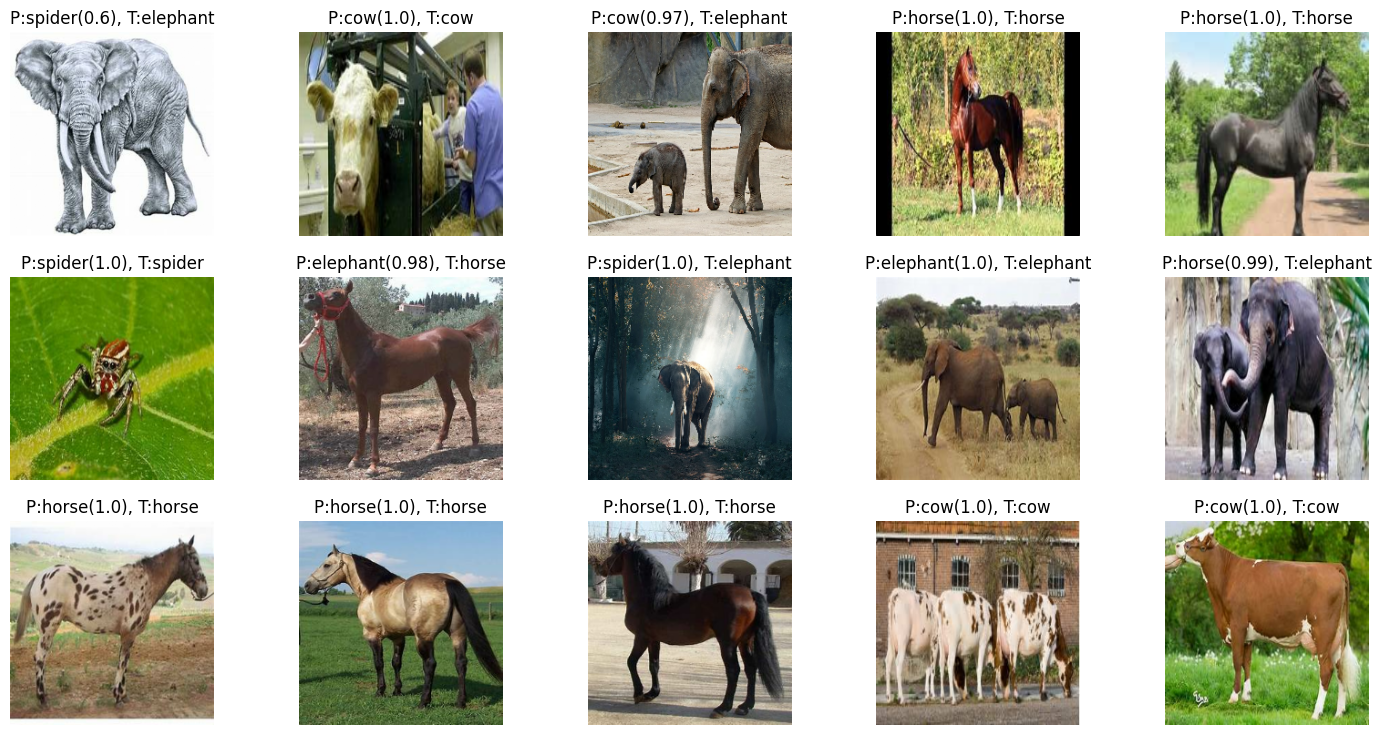

In [26]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "Valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
  valid_path,
  label_mode='int',
  color_mode='rgb',
  batch_size=training_config.BATCH_SIZE,
  image_size=data_config.DATA_SHAPE[:2],
  shuffle=True, # shuffling to show images from all classes
)

get_sample_predictions(model=trained_model, dataset=valid_dataset)

# <font style="color:red">Step 6. Display Confusion Matrix [5 Points]</font>

Display the confusion matrix (Refer to the earlier lectures on Performance Metrics for this).


This is what the output should look like:

<img src='https://www.dropbox.com/scl/fi/wkxfij6f9bnrcttwzddey/c4_project_a1_confusion_matrix.png?rlkey=0gwpb3owe5omngkq138azjslx&dl=1' width=600>


Found 786 files belonging to 4 classes.
786/786 [==============================] - 3s 3ms/step


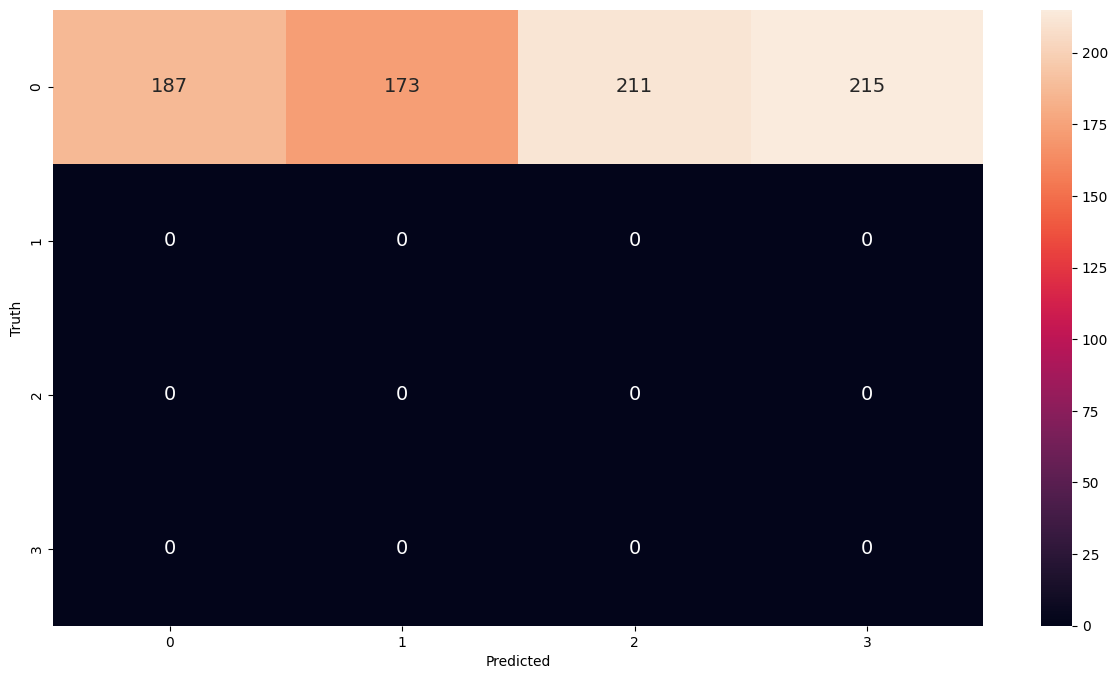

In [23]:
### YOUR CODE HERE

ds = tf.keras.utils.image_dataset_from_directory(
  f"{DatasetConfig.DATA_ROOT}/Valid",
  label_mode='int',
  color_mode='rgb',
  batch_size=1,
  image_size=DatasetConfig.DATA_SHAPE[:2],
  shuffle=False, # shuffling to show images from all classes
)

# valid_labels = [int(np.argmax(label.numpy())) for _, label in valid_dataset]
valid_labels = []
for _, label in ds:
  valid_labels.append(int(np.argmax(label.numpy())))

predictions = trained_model.predict(ds)
predicted_labels = [np.argmax(i) for i in predictions]


# print(valid_labels.__len__())
# print(predicted_labels.__len__())

cm = tf.math.confusion_matrix(labels=valid_labels, predictions=predicted_labels)

plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

###

# <font style="color:red">Step 7. Generate Submission File [5 Points]</font>


**TASK**

1. Generate predictions on the test set.
2. Create a submission `.csv` file.
3. Upload the `.csv` file on Kaggle.


**REFERENCE**
1. **`test.csv`** -  This CSV file contains image IDs for the test set. Read this CSV file to generate predictions for each test image.

2. **`sample_submission.csv`** - Refer to this file to understand the structure of the csv file to be submitted. The sample_submission file is only to be used as reference. <br>
It contains columns:
    1. **`ID`**: same as the test.csv file
    2. **`CLASS`**: which contains random predictions




**<font style="color:red">Use the same column names that are given in the`sample_submission.csv` file.</font>**


In [28]:
import pandas as pd


### YOUR CODE HERE

test_images = sorted(glob.glob(f"{DatasetConfig.DATA_ROOT}/Test/*.jpg"))

test_ds = tf.keras.utils.image_dataset_from_directory(
  f"{DatasetConfig.DATA_ROOT}/Test",
  label_mode=None,  # Set label_mode to None to create a dataset without labels
  color_mode='rgb',
  batch_size=1,
  image_size=DatasetConfig.DATA_SHAPE[:2],  # Set your desired image size
  shuffle=False  # No need to shuffle test data
)


# Define a function for making predictions on the test dataset
def make_predictions_and_save_csv(model, test_ds, test_images, idx_to_cls, csv_filename="submission.csv"):
  predictions = model.predict(test_ds)

  predicted_labels = [idx_to_cls[np.argmax(pred)] for pred in predictions]

  # Extract image IDs from the test dataset
  image_ids = [os.path.basename(image) for image in test_images]

  # Create a DataFrame with image IDs and predicted classes
  submission_df = pd.DataFrame({
    'ID': image_ids,
    'CLASS': predicted_labels
  })
  # Save the DataFrame to a CSV file
  submission_df.to_csv(csv_filename, index=False)


make_predictions_and_save_csv(
  trained_model,
  test_ds,
  test_images,
  {0: "cow", 1: "elephant", 2: "horse", 3: "spider"},
  "submission.csv",
)

###

Found 1639 files belonging to 1 classes.
1639/1639 [==============================] - 6s 4ms/step


## <font style="color:red">Step 8. Kaggle Submission Score [50 Points]</font>

**For full points, you need to achieve atleast `85%` accuracy on the Public Test leaderboard. If accuracy is less than `80%`, you gain no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, in order to get evaluated for this section.**

**Please share your profile link, user id and score achieved.**

```
URL: https://www.kaggle.com/darkestmedium
Profile Name: darkestmedium
Points Scored: 0.72405
```

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other.</font>**